# Machine Learning Engineer Nanodegree
## Model Evaluation & Validation


## Getting Started
The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration
In this first section of this project, you will make a cursory investigation about the Boston housing data and provide your observations. Familiarizing yourself with the data through an explorative process is a fundamental practice to help you better understand and justify your results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics
For your very first coding implementation, you will calculate descriptive statistics about the Boston housing prices. Since `numpy` has already been imported for you, use this library to perform the necessary calculations. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below, you will need to implement the following:
- Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
  - Store each calculation in their respective variable.

In [18]:
# TODO: Minimum price of the data
minimum_price = np.amin(prices)

# TODO: Maximum price of the data
maximum_price = np.amax(prices)

# TODO: Mean price of the data
mean_price = np.mean(prices)

# TODO: Median price of the data
median_price = np.median(prices)

# TODO: Standard deviation of prices of the data
std_price = np.std(prices) # Or std_price = prices.std(ddof =0) where degree of freedom = 0 is for ppl, 1 for sample

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


### Question 1 - Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.


** Using your intuition, for each of the three features above, do you think that an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`? Justify your answer for each.**

**Hint:** This problem can phrased using examples like below.  
* Would you expect a home that has an `'RM'` value(number of rooms) of 6 be worth more or less than a home that has an `'RM'` value of 7?
* Would you expect a neighborhood that has an `'LSTAT'` value(percent of lower class workers) of 15 have home prices be worth more or less than a neighborhood that has an `'LSTAT'` value of 20?
* Would you expect a neighborhood that has an `'PTRATIO'` value(ratio of students to teachers) of 10 have home prices be worth more or less than a neighborhood that has an `'PTRATIO'` value of 15?

**Answer: ** 
* `'RM'`: An increase in number of rooms means an increase in a housing size, thus a housing price (`'MEDV'` value) increases. 
* `'LSTAT'`: As the percentage of "lower class workers" increases in the neighborhood, the value of the housing price drops because the demand for houses in the neighborhood drops. Thus, an increase in `'LSTAT'` value means a decrease in a housing price (`'MEDV'` value). 
* `'PTRATIO'`: Having low `'PTRATIO'` value means teachers can generally take better care of more students because of high ratio of students to teachers. Generally this kind of schools provide better care and needs for individual students, thus ends up providing a better education. As the demand for such schools increases, a housing value (`'MEDV'` value) in the same neighborhood increases as well. 

These can be confirmed by plotting each feature vs MEDV housing prices below.

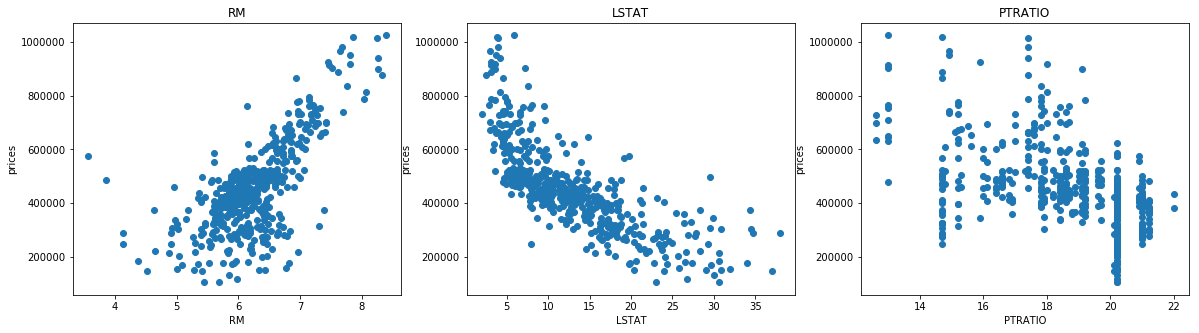

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, i+1)
    plt.plot(data[col], prices, 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')

----

## Developing a Model
In this second section of the project, you will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, you will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

For the `performance_metric` function in the code cell below, you will need to implement the following:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [5]:
# TODO: Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Question 2 - Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

Run the code cell below to use the `performance_metric` function and calculate this model's coefficient of determination.

In [7]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

Model has a coefficient of determination, R^2, of 0.923.


* Would you consider this model to have successfully captured the variation of the target variable? 
* Why or why not?

** Hint: **  The R2 score is the proportion of the variance in the dependent variable that is predictable from the independent variable. In other words:
* R2 score of 0 means that the dependent variable cannot be predicted from the independent variable.
* R2 score of 1 means the dependent variable can be predicted from the independent variable.
* R2 score between 0 and 1 indicates the extent to which the dependent variable is predictable. An 
* R2 score of 0.40 means that 40 percent of the variance in Y is predictable from X.

**Answer:** This model have successfully captured the variation of the target variable. It's because the calculated R^2 score of 0.923 is close to 1, where R^2 score of 1 means a perfect model as the dependent variable can be always predicted from the independent variable. The following model has predicted the variance in Y from independent variable X, 92.3% of the time. 

However, there are two caveats here:
* We only have five points here, and it may be hard to draw conclusion that is statistically significant.
* Whether the model is successful also depends largely on the application. So for some projects 0.923 is sufficient, whereas for others it could be a low score.

### Implementation: Shuffle and Split Data
Your next implementation requires that you take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, you will need to implement the following:
- Use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to a value of your choice. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [8]:
# TODO: Import 'train_test_split'
from sklearn.cross_validation import train_test_split

# TODO: Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, 
                                                    random_state=1)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


### Question 3 - Training and Testing

* What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?

**Hint:** Think about how overfitting or underfitting is contingent upon how splits on data is done.

**Answer: ** Because of the "golden rule" of machine learning, where testing sets can never be used for training, splitting a training dataset into some ratio of training and testing is useful in making a better training model. It gives a better estimation of how well the trianing model makes a prediction on an independent data (testing subsets). Moreover, this protect the model against overfitting, which occurs due to a high variance. 

----

## Analyzing Model Performance
In this third section of the project, you'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, you'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

Run the code cell below and use these graphs to answer the following question.

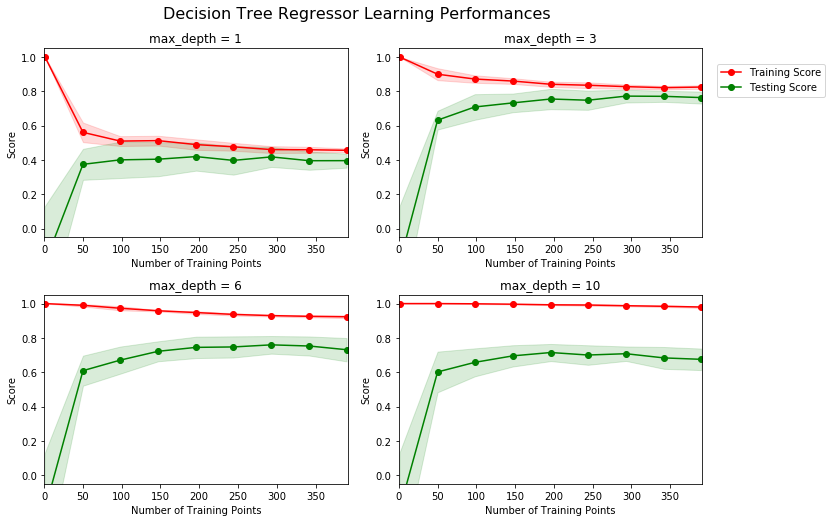

In [9]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Question 4 - Learning the Data
* Choose one of the graphs above and state the maximum depth for the model. 
* What happens to the score of the training curve as more training points are added? What about the testing curve? 
* Would having more training points benefit the model? 

**Hint:** Are the learning curves converging to particular scores? Generally speaking, the more data you have, the better. But if your training and testing curves are converging with a score above your benchmark threshold, would this be necessary?
Think about the pros and cons of adding more training points based on if the training and testing curves are converging.

**Answer: ** A learning curve of maximum depth of 3, shows an exponential decrease in training score curve. A score value converges to 0.8 as more training points are added. However, a score of testing curve increases as more training poitns are added and also converges to 0.8. As the score converges to a certain value as more training points are added, having training points of approximately more than 300 does not benefit the model. Similarly, having more training points of about 300 wouldn't benefit the model for all four graphs, as it's meaningless and expensive. 

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

** Run the code cell below and use this graph to answer the following two questions Q5 and Q6. **

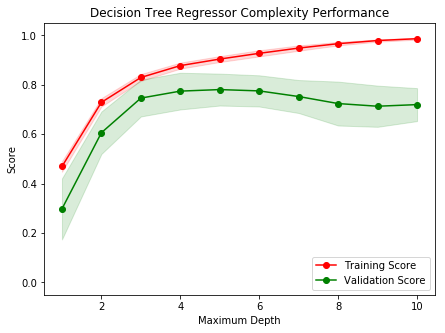

In [10]:
vs.ModelComplexity(X_train, y_train)

### Question 5 - Bias-Variance Tradeoff
* When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? 
* How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?

**Hint:** High bias is a sign of underfitting(model is not complex enough to pick up the nuances in the data) and high variance is a sign of overfitting(model is by-hearting the data and cannot generalize well). Think about which model(depth 1 or 10) aligns with which part of the tradeoff.

**Answer: ** 
* The model suffer from high bias with a maximum depth of 1, because both training and validtaion scores are low. The model is underfitting, as it has high errors even on training sets. 
* The model suffer from high variance with a maximum depth of 10. A training score is as high as 1 but a validation score is much lower than the training score. A validation score is 0.6. Thus, the model is overfitting to the training sets. 

### Question 6 - Best-Guess Optimal Model
* Which maximum depth do you think results in a model that best generalizes to unseen data? 
* What intuition lead you to this answer?

** Hint: ** Look at the graph above Question 5 and see where the validation scores lie for the various depths that have been assigned to the model. Does it get better with increased depth? At what point do we get our best validation score without overcomplicating our model? And remember, Occams Razor states "Among competing hypotheses, the one with the fewest assumptions should be selected."

**Answer: ** 
The model with a maximum depth of 4 seems like the best in generalizing the unseen data. At max depth of 4, validation score curve reaches the maximum point, thus the model is just right. The validation score increases till maximum depth of 4 and decreases afterwards. It's neither underfitting nor overfitting.  

-----

## Evaluating Model Performance
In this final section of the project, you will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Question 7 - Grid Search
* What is the grid search technique?
* How it can be applied to optimize a learning algorithm?

** Hint: ** When explaining the Grid Search technique, be sure to touch upon why it is used,  what the 'grid' entails and what the end goal of this method is. To solidify your answer, you can also give an example of a parameter in a model that can be optimized using this approach.

**Answer: ** The grid search technique is typically used when there are more than one hyperparameters. It finds all combinations of hyperparameters of a learning algorithm exhaustively to optimize the performance of estimator with just a few lines of code. It must be guided by some performance metric. Cross-validation is usually used to calculate evaluation scores for each combinations found from the grid search, then choose the right combination with the best evaluation score. Instead of using cross-validation, evaluation can also be done on the held-out validation set. The grid search is useful as it does the exhaustive work of finding the right combinations of hyperparameters very easily. When training a Support Vector Classification model, the grid search can be used to find the optimal combinations of its hyperparameters like 'kernel' and 'gamma'.

However, due to its exhaustive search nature, grid search can be computationally expensive, especially when data size is large and model is complicated. Sometimes we resort to randomized search in this case to search only some combinations of the parameters.

### Question 8 - Cross-Validation

* What is the k-fold cross-validation training technique? 

* What benefit does this technique provide for grid search when optimizing a model?

**Hint:** When explaining the k-fold cross validation technique, be sure to touch upon what 'k' is, how the dataset is split into different parts for training and testing and the number of times it is run based on the 'k' value.

When thinking about how k-fold cross validation helps grid search, think about the main drawbacks of grid search which are hinged upon **using a particular subset of data for training or testing** and how k-fold cv could help alleviate that. You can refer to the [docs](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) for your answer.

**Answer: ** 
* The k-fold cross validation is to separate the data into 'k' sets. Then, the model is trained 'k' times using 'k' different sets of data as a testing set. Thus, each time one of 'k' sets is used for testing and the 'k-1' sets are used for training. The answer is the average of 'k' different test results. Obtaining the average of 'k' different results gives a more accurate model with the better estimation for the average error rate. K-fold cross validation is useful as every data is used for both testing and training and used as a testing set exactly once. It's also useful as we can choose the size 'k' independently. 
* K-fold cross-validalition is beneficial for grid search. A grid search does an exhaustive search for optimal combinations of hyperparameters. When optimizing a model, evaluation can be done on the cross validation training set or done on the held-out single validation set, which is a particular subset of training data used independently as a testing set. When it's done on the held-out validation set, there's a high chance that we are specializing our model to fit the specific single validation set, so the model won't generalize well. In addition, if the amount of data to train the model is not enough due to a separation of training dataset, it's likely to result in a high bias. Therefore, the usage of grid search with k-fold cross-validation is more beneficial. 

### Implementation: Fitting a Model
Your final implementation requires that you bring everything together and train a model using the **decision tree algorithm**. To ensure that you are producing an optimized model, you will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, you will find your implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique you describe in **Question 8**, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. While you're working on your implementation, think about the contrasts and similarities it has to the K-fold cross-validation technique.

Please note that ShuffleSplit has different parameters in scikit-learn versions 0.17 and 0.18.
For the `fit_model` function in the code cell below, you will need to implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [13]:
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # TODO: Create a decision tree regressor object
    # Could also set a random_state for reproducible results.
    regressor = DecisionTreeRegressor(random_state = 100)

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': np.arange(1,11)}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # GridSearch searches for the highest validation score on the different data splits in this ShuffleSplit.
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### For Thought: why using ShuffleSplit instead of KFold for cross validation here?
One reason why we would prefer ShuffleSplit over KFold is that we can specify the number of iterations independent 
of the splitting ratio. For example, if we set K=5 in K-fold CV, the data is splitting into 80% for training 
and 20% for validation, and this is iterated 5 times. However, what if we want to have only 3 iteration with the 
same splitting ratio? we can set test_size of ShuffleSplit to 0.2, and set n_splits to 3. Thus, we can see that 
ShuffleSplit is more flexible. This is the major reason why we are using ShuffleSplit here. Otherwise we cannot 
achieve 10 iterations with 80%-20% splitting using KFold.

The K-fold CV does have one advantage over the shuffle split method: each data is used exactly once, guaranteed. However, the advantage is less obvious, as the implementation of shuffle split still tries to ensure the validation data in each run is different. This is especially the case for large data sets.

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Question 9 - Optimal Model

* What maximum depth does the optimal model have? How does this result compare to your guess in **Question 6**?  

Run the code block below to fit the decision tree regressor to the training data and produce an optimal model.

In [14]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 5 for the optimal model.


** Hint: ** The answer comes from the output of the code snipped above.

**Answer: ** maximum depth is 5 for the optimal model, which is close to the question 6 answer of max depth 4.

### Question 10 - Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* What price would you recommend each client sell his/her home at? 
* Do these prices seem reasonable given the values for the respective features? 

**Hint:** Use the statistics you calculated in the **Data Exploration** section to help justify your response.  Of the three clients, client 3 has has the biggest house, in the best public school neighborhood with the lowest poverty level; while client 2 has the smallest house, in a neighborhood with a relatively high poverty rate and not the best public schools.

Run the code block below to have your optimized model make predictions for each client's home.

In [15]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

Predicted selling price for Client 1's home: $419,700.00
Predicted selling price for Client 2's home: $287,100.00
Predicted selling price for Client 3's home: $927,500.00


**Answer: ** I would recommend 419,700.00 dollars to client 1, 287,100.00 dollars to client 2 and 927,500.00 dollars to client 3. These predicted prices seem reasonable given the respsective features. First of all, comparing clients' total number of rooms and housing prices, the more they have rooms in their house, the greater their predicted housing values are. Secondly, the lower their neighborhood poverty rate is, the higher their predicted housing prices are. Lastly, the smaller the student-to-teacher ratio of their nearby school is, the higher their predicted housing prices are. The correlation between housing features and housing prices from question 1 corresponds to the predicted housing prices of client 1, 2 and 3. 
Basic statistics summary of Boston houses also supports this trend. As predicted, client 2's home has the smallest housing value, followed by client 1 and client 3. The histogram below also visualizes where each of the predictions fall.

               RM       LSTAT     PTRATIO
count  489.000000  489.000000  489.000000
mean     6.240288   12.939632   18.516564
std      0.643650    7.081990    2.111268
min      3.561000    1.980000   12.600000
25%      5.880000    7.370000   17.400000
50%      6.185000   11.690000   19.100000
75%      6.575000   17.120000   20.200000
max      8.398000   37.970000   22.000000


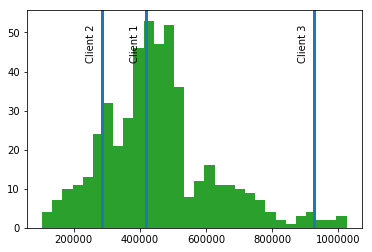

In [16]:
# five number summary of the descriptive stats of the features
print features.describe()

# histogram of all of the housing prices in this dataset
import matplotlib.pyplot as plt
for i,price in enumerate(reg.predict(client_data)):
    plt.hist(prices, bins = 30)
    plt.axvline(price, lw = 3)
    plt.text(price-50000, 50, 'Client '+str(i+1), rotation=90)

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

**Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.**

In [17]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $69,044.61


### Question 11 - Applicability

* In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.  

**Hint:** Take a look at the range in prices as calculated in the code snippet above. Some questions to answering:
- How relevant today is data that was collected from 1978? How important is inflation?
- Are the features present in the data sufficient to describe a home? Do you think factors like quality of apppliances in the home, square feet of the plot area, presence of pool or not etc should factor in?
- Is the model robust enough to make consistent predictions?
- Would data collected in an urban city like Boston be applicable in a rural city?
- Is it fair to judge the price of an individual home based on the characteristics of the entire neighborhood?

**Answer: ** I believe the following prediction model, which was constructed using Boston housing data from 1978, is highly inapplicable for today. Over the last few years, housing prices have increased significantly in large cities due to and industralization and a signifcant increase in urban population. Hence, predictions can't be made for today using this model. Addition of features would increase the accuracy of the data, but there's a danger that the overusage of features might lead to overfitting. Maybe one or two more features would be sufficient enough to describe a home. However, simply using the characteristics of the entire neighborhood to judge the price of an individual home wouldn't be fair. Although neighborhood affects housign prices to some extent, housing vaue doesn't entirely depend on the neighborhood. As I mentioned above, there has been a significant increase in urban population over the last few years. In other words, population in a rural city has decreased, which has led to an increase in urban population. Thus, the data collected in an urban city like Boston can hardly be applicable in a rural city. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.